# Packages and Libraries

# Work FLow
- `Packages and Libraries`
-  `Load raw audio data` from files in .WAV format that can be processed
-  `EDA`
-  `Spectral Representations` Convert the audio signal into a frequency domain representation, such as a spectrogram or mel spectrogram.
-  `Conversion to TensorFlow` Convert the preprocessed data into a format suitable for the deep learning framework.
-  `Data Splitting` Split the dataset into training, validation, and testing sets.
-  `Model Building` Build your machine learning model using the preprocessed data.
-  `Converting to TFLite model`

In [1]:
import os
import json
import math
import wave
import h5py
import librosa
import pathlib
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile as sf
import tensorflow as tf 
from sys import getsizeof
from tensorflow import keras
import matplotlib.pyplot as plt
import IPython.display as display
from IPython.display import Audio
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

2024-02-21 12:06:54.740285: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-21 12:06:54.864405: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 12:06:54.864461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 12:06:54.866892: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 12:06:54.883510: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-21 12:06:54.884379: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Disable TensorFlow warnings and info messages
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Loading Raw Audio Data

The dataset's audio clips are of 6 classes and stored in six folders corresponding to each speech command: 
- `ddyo`
- `kkono`
- `mu maaso`
- `emabega`
- `yimirira`
- `gaali`

## Mount google drive
adisamproject@gmail.com

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# DATASET_PATH = "/content/drive/My Drive/2_Luganda/dataset"
# data_dir = pathlib.Path(DATASET_PATH)

## Dataset path

In [4]:
TRAIN_DATASET_PATH = 'Dataset/Train'
TEST_DATASET_PATH = 'Dataset/Test'

train_data_dir = pathlib.Path(TRAIN_DATASET_PATH)
test_data_dir = pathlib.Path(TEST_DATASET_PATH)

# Exploratory Data Analysis (EDA) 

## Labels (Train and Test Directories)

In [5]:
commands = np.array(tf.io.gfile.listdir(str(train_data_dir)))
print('Train commands labels:\n', commands)

Train commands labels:
 ['emabega' 'ddyo' 'gaali' 'kkono' 'mu masso' 'yimirira']


In [6]:
commands = np.array(tf.io.gfile.listdir(str(test_data_dir)))
print('Test commands labels:\n', commands)

Test commands labels:
 ['emabega' 'ddyo' 'gaali' 'kkono' 'mu masso' 'yimirira']


## Number of audio files

In [7]:
def count_audio_files_in_subfolders(data_dir):
    counts = {}
    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)

        if os.path.isdir(subfolder_path):
            audio_files_count = len([f for f in os.listdir(subfolder_path) if f.endswith('.wav')])
            counts[subfolder] = audio_files_count

    return counts

### Training dataset

In [8]:
counts = count_audio_files_in_subfolders(train_data_dir)

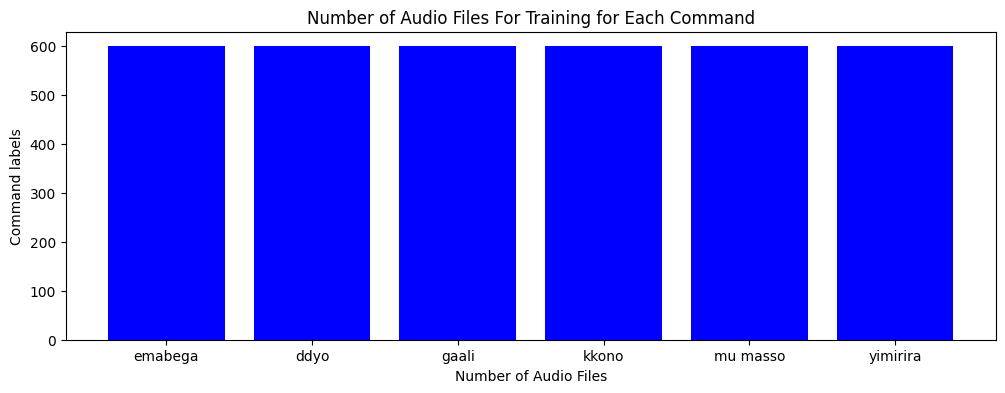

In [9]:
plt.figure(figsize=(12, 4))
plt.bar(list(counts.keys()), list(counts.values()), color='blue')
plt.xlabel('Number of Audio Files')
plt.ylabel('Command labels')
plt.title('Number of Audio Files For Training for Each Command')
plt.show()

### Test dataset

In [10]:
counts = count_audio_files_in_subfolders(test_data_dir)

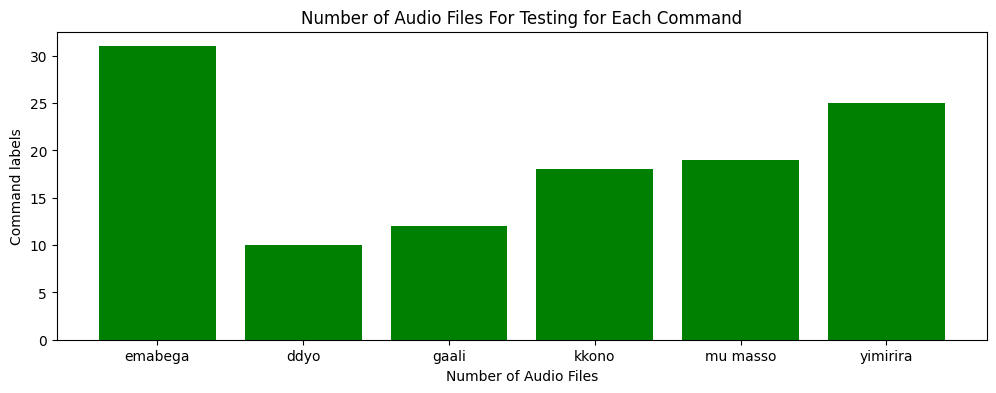

In [11]:
plt.figure(figsize=(12, 4))
plt.bar(list(counts.keys()), list(counts.values()), color='green')
plt.xlabel('Number of Audio Files')
plt.ylabel('Command labels')
plt.title('Number of Audio Files For Testing for Each Command')
plt.show()

## Audio Properties and Parameters
- using one audio file

In [12]:
SAMPLE_RATE = 16000

In [13]:
example_audio_path = os.path.join(TRAIN_DATASET_PATH, 'emabega', 'audio #4251.wav')
audio_signal, sample_rate = librosa.load(example_audio_path, sr=SAMPLE_RATE)
audio = wave.open(example_audio_path, 'rb')

In [14]:
num_channels = audio.getnchannels()
sample_width = audio.getsampwidth()
frame_rate = audio.getframerate()
num_frames = audio.getnframes()
duration = num_frames / float(frame_rate)

In [15]:
print("Number of channels:    ", num_channels)
print("Sample width (bytes):  ", sample_width)
print("Frame rate (Hz):       ", frame_rate)
print("Number of frames:      ", num_frames)
print("Duration (s):          ", duration)
print("Parameters:            ", audio.getparams())

Number of channels:     1
Sample width (bytes):   2
Frame rate (Hz):        16000
Number of frames:       20160
Duration (s):           1.26
Parameters:             _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=20160, comptype='NONE', compname='not compressed')


In [16]:
audio.close()

### Visualize the audio waveform

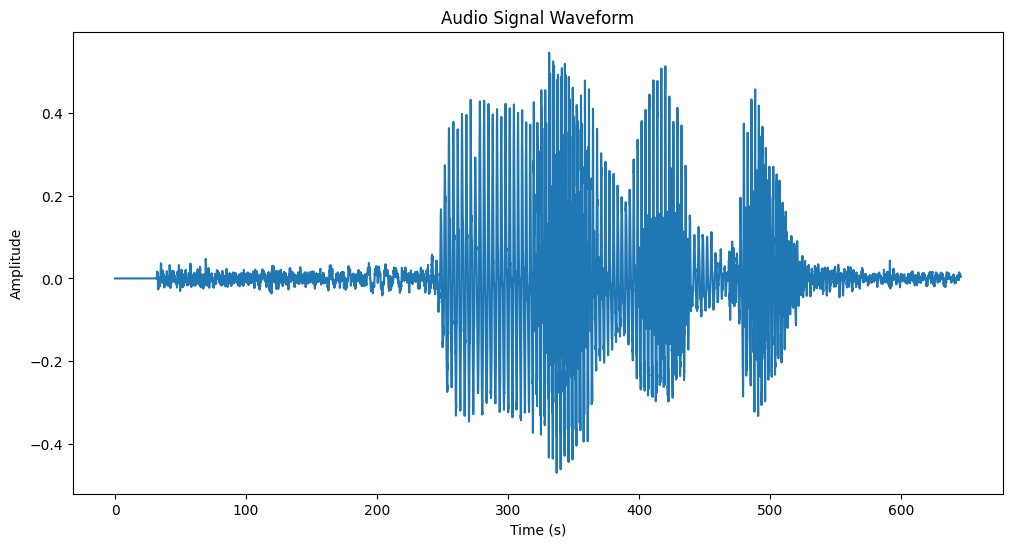

In [17]:
time = librosa.times_like(audio_signal, sr=SAMPLE_RATE)

plt.figure(figsize=(12, 6))
plt.plot(time, audio_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio Signal Waveform')
plt.show()

### Amplitude Distribution

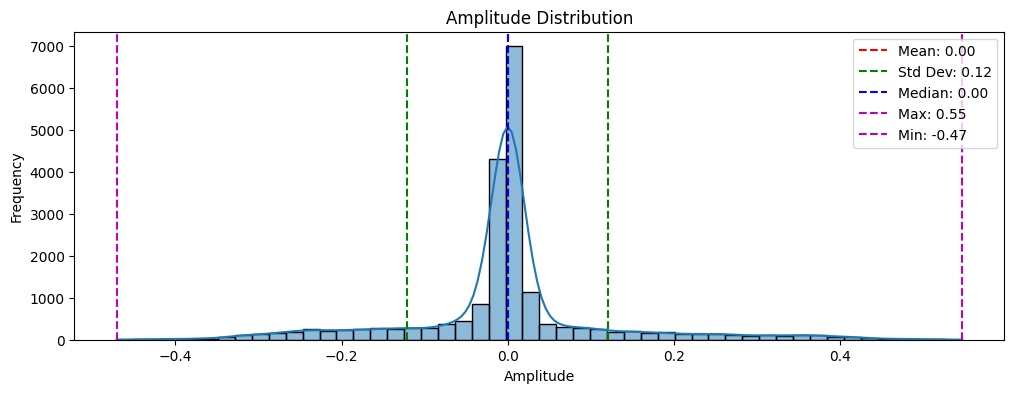

In [18]:
# Calculate statistical summary information
mean_amplitude = np.mean(audio_signal)
std_deviation = np.std(audio_signal)
max_amplitude = np.max(audio_signal)
min_amplitude = np.min(audio_signal)
median_amplitude = np.median(audio_signal)

# Plot the histogram with additional features
plt.figure(figsize=(12, 4))

# Plot the histogram
sns.histplot(audio_signal, bins=50, kde=True)

# Add vertical lines for statistical summary information
plt.axvline(mean_amplitude, color='r', linestyle='--', label=f'Mean: {mean_amplitude:.2f}')
plt.axvline(mean_amplitude + std_deviation, color='g', linestyle='--', label=f'Std Dev: {std_deviation:.2f}')
plt.axvline(mean_amplitude - std_deviation, color='g', linestyle='--')
plt.axvline(median_amplitude, color='b', linestyle='--', label=f'Median: {median_amplitude:.2f}')
plt.axvline(max_amplitude, color='m', linestyle='--', label=f'Max: {max_amplitude:.2f}')
plt.axvline(min_amplitude, color='m', linestyle='--', label=f'Min: {min_amplitude:.2f}')

# Set plot title and labels
plt.title('Amplitude Distribution')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Play audio file

In [19]:
Audio(example_audio_path)

# Split into Train and validation

In [20]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=train_data_dir,
    batch_size=64,
    validation_split=0.28,
    seed=0,
    output_sequence_length=SAMPLE_RATE,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 3600 files belonging to 6 classes.
Using 2592 files for training.
Using 1008 files for validation.

label names: ['ddyo' 'emabega' 'gaali' 'kkono' 'mu masso' 'yimirira']


## The shape of the audio clip
- (batch, samples, channels)

In [21]:
element_spec = train_ds.element_spec
print(element_spec)

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [22]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [23]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [24]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


# Preparing Test dataset

In [25]:
test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=test_data_dir,
    batch_size=64,
    validation_split=None,  # No need to split the test dataset
    seed=0,
    output_sequence_length=SAMPLE_RATE,
    shuffle=False  # Disable shuffling for the test dataset
)

test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

# Shard the test dataset
test_ds = test_ds.shard(num_shards=2, index=0)

Found 115 files belonging to 6 classes.


In [26]:
for example_audio, example_labels in test_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


# Plot a few audio waveforms:

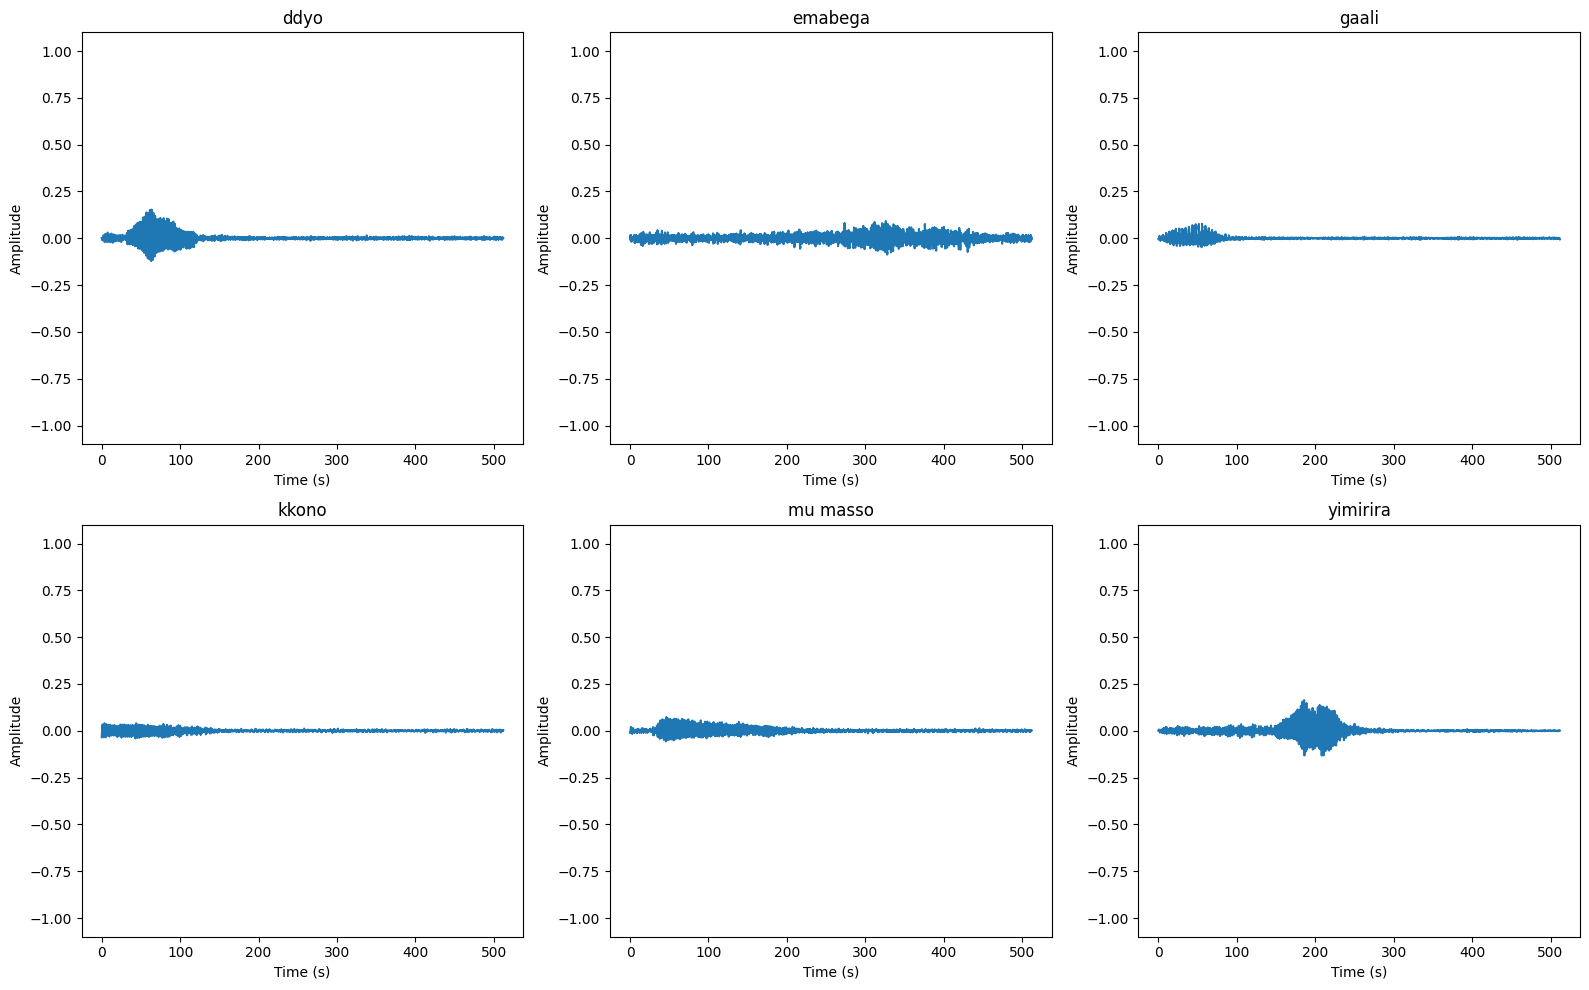

In [27]:
import librosa.display

label_names_slice = label_names[:6]  # Select the first six labels
plt.figure(figsize=(16, 10))
rows = 2
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    time = librosa.times_like(audio_signal, sr=SAMPLE_RATE)
    plt.plot(time, audio_signal)
    plt.title(label_names_slice[i])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.ylim([-1.1, 1.1])
plt.tight_layout()
plt.show()


# Feature Extraction

In [28]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

## Tensorized waveform
The shapes of a tensorized waveform and the corresponding spectrogram, and play the original audio.

In [29]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


### Visualization of spectrogram

In [30]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
      
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

### Plot of waveform and spectrogram.

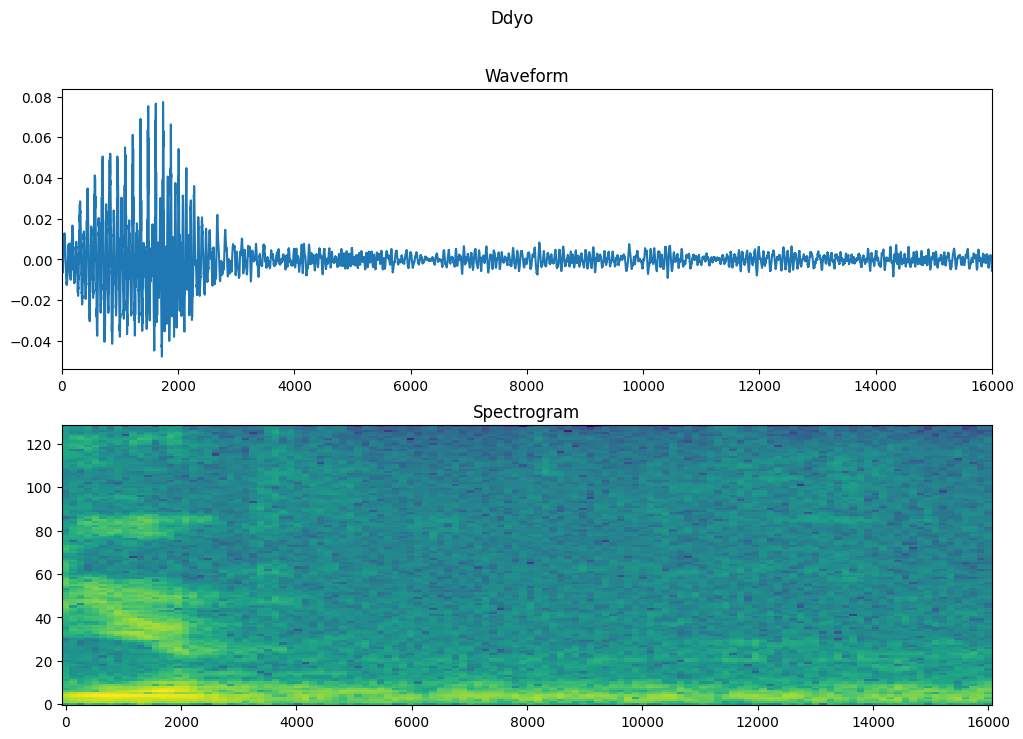

In [31]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

## Create spectrogram datasets

In [32]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [33]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

## Visualization of the spectrograms

In [34]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

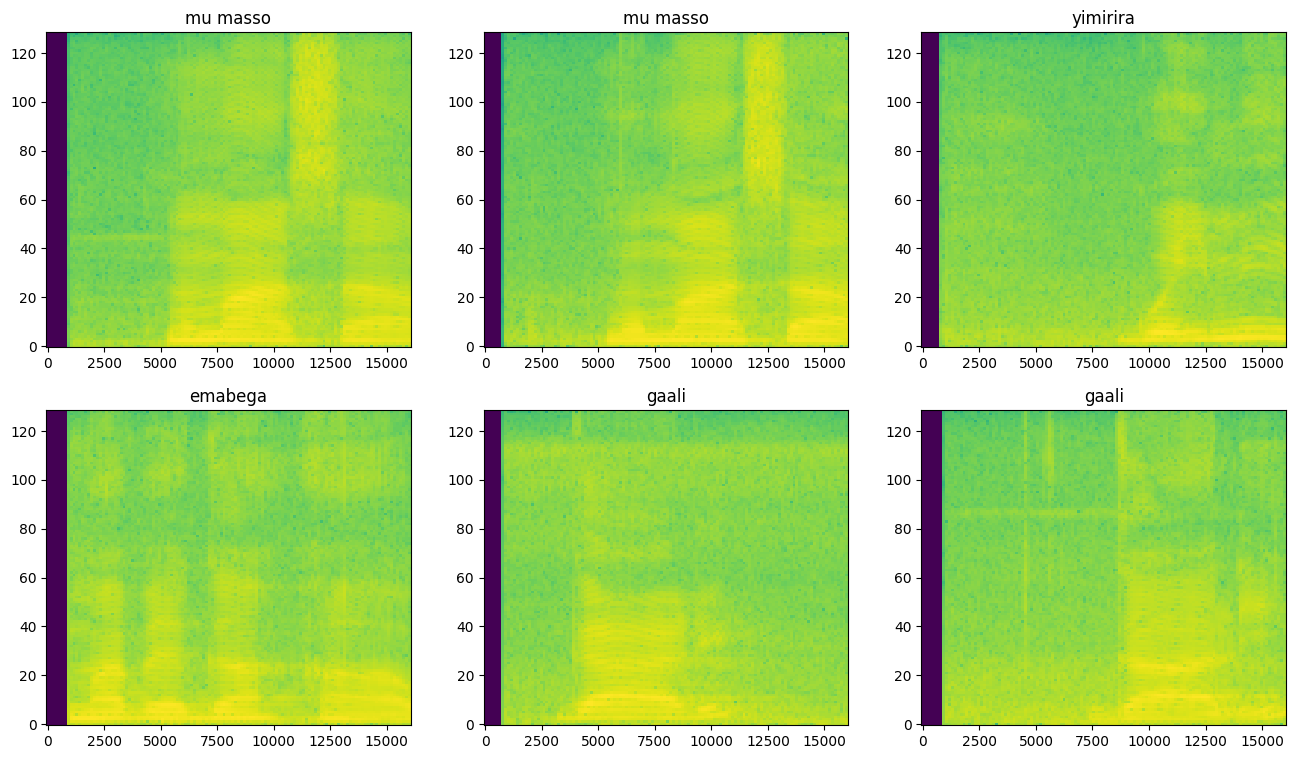

In [35]:
rows = 2
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

 `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [36]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [37]:
train_spectrogram_ds


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Building Models

## Model 1

1. Input layer: Accepts input data of shape `input_shape`.
2. Conv2D layer with 32 filters, kernel size 3x3, and ReLU activation. Dilated convolution with dilation rate (2, 2).
3. MaxPooling2D layer.
4. Conv2D layer with 64 filters, kernel size 3x3, and ReLU activation. Dilated convolution with dilation rate (2, 2).
5. GlobalAveragePooling2D layer: Reduces spatial dimensions to 1x1.
6. Dense layer with 64 neurons and ReLU activation.
7. Dropout layer with dropout rate of 0.5.
8. Dense output layer with `num_labels` neurons (output classes).


### Input shape 

In [40]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

Input shape: (124, 129, 1)


### Model Arch

In [41]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 120, 125, 32)      320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 60, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 58, 64)        18496     
                                                                 
 global_average_pooling2d_1  (None, 64)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

### Compile the model

In [42]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [43]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
41/41 [==============================] - 61s 1s/step - loss: 1.7400 - accuracy: 0.2006 - val_loss: 1.6575 - val_accuracy: 0.2440
Epoch 2/20
41/41 [==============================] - 56s 1s/step - loss: 1.5509 - accuracy: 0.3931 - val_loss: 1.3640 - val_accuracy: 0.5786
Epoch 3/20
41/41 [==============================] - 55s 1s/step - loss: 1.2356 - accuracy: 0.5517 - val_loss: 1.0347 - val_accuracy: 0.6290
Epoch 4/20
41/41 [==============================] - 55s 1s/step - loss: 1.0095 - accuracy: 0.6080 - val_loss: 0.8340 - val_accuracy: 0.7117
Epoch 5/20
41/41 [==============================] - 55s 1s/step - loss: 0.8674 - accuracy: 0.6713 - val_loss: 0.7036 - val_accuracy: 0.7581
Epoch 6/20
41/41 [==============================] - 55s 1s/step - loss: 0.7618 - accuracy: 0.7141 - val_loss: 0.6605 - val_accuracy: 0.7661
Epoch 7/20
41/41 [==============================] - 55s 1s/step - loss: 0.6757 - accuracy: 0.7504 - val_loss: 0.5367 - val_accuracy: 0.8105
Epoch 8/20
41/41 [==

### Plot Accuracy and Loss

Text(0, 0.5, 'Accuracy [%]')

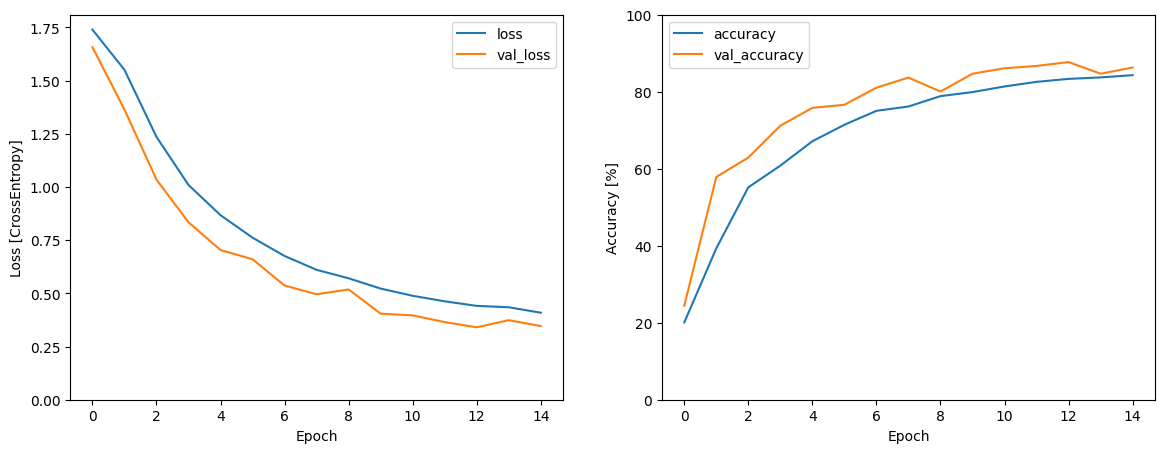

In [44]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [45]:
model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 [==============================] - 1s 974ms/step - loss: 2.0327 - accuracy: 0.2656


{'loss': 2.0326857566833496, 'accuracy': 0.265625}

In [46]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

1/1 [==============================] - 1s 1s/step


In [47]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.27447916666666666
Recall: 0.265625
F1-score: 0.2699795081967213


### Display the confusion matix

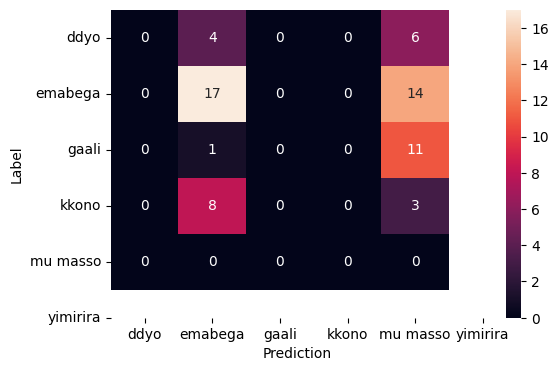

In [48]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Function to determine the size of the model

In [49]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [50]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

## Tensorflow model

In [51]:
KERAS_MODEL_NAME = "my_model_1.keras"
model.save(KERAS_MODEL_NAME)

In [55]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "KB")

File size: 310.557 Kilobytes


## TFLite Model for model

In [56]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

2024-02-21 12:36:38.359266: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-21 12:36:38.359331: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-21 12:36:38.359768: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp1ygs1rdg
2024-02-21 12:36:38.363114: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-21 12:36:38.363160: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp1ygs1rdg
2024-02-21 12:36:38.371896: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-21 12:36:38.479639: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp1ygs1rdg
2024-02-21 12:36:38.513416: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 153649 

In [57]:
# Load the TensorFlow Lite model:
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()


In [58]:
# input shape
input_details = interpreter.get_input_details()
input_shape = input_details[0]['shape']
print('Input shape:', input_shape)

Input shape: [  1 124 129   1]


In [59]:
# output shape
output_details = interpreter.get_output_details()
output_shape = output_details[0]['shape']
print('Output shape:', output_shape)

Output shape: [1 6]


In [60]:
# Prepare the test dataset 
test_spectrogram_ds = test_spectrogram_ds.unbatch().batch(1)

In [61]:
# Run inference on the test dataset and collect predictions:
y_true = []
y_pred = []

for spectrogram, label in test_spectrogram_ds:
    # Perform inference
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

    # Collect predictions
    y_true.append(label.numpy()[0])
    y_pred.append(np.argmax(output))


In [62]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')


Accuracy is 26%


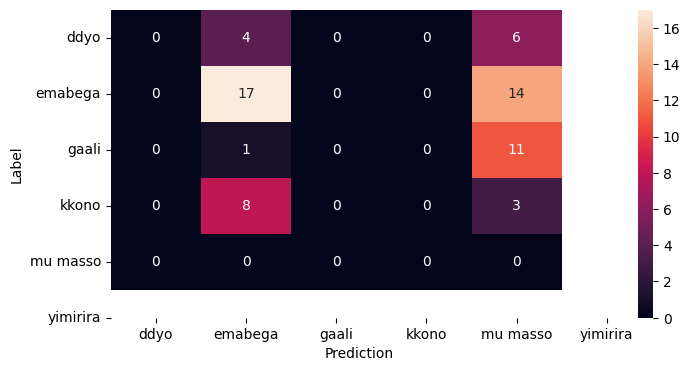

In [63]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [64]:
convert_bytes(get_file_size("model.tflite"), "KB")

File size: 96.137 Kilobytes


## Quntized model

In [65]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Quantize the TensorFlow Lite model
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)


2024-02-21 12:36:50.879839: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-21 12:36:50.879898: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-21 12:36:50.880334: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpd_bld3k_
2024-02-21 12:36:50.883692: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-21 12:36:50.883737: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpd_bld3k_
2024-02-21 12:36:50.892291: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-21 12:36:51.000458: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpd_bld3k_
2024-02-21 12:36:51.052626: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 172293 

In [66]:
convert_bytes(get_file_size("quantized_model.tflite"), "KB")

File size: 30.992 Kilobytes


In [67]:
# Evaluate the model on the test dataset
correct = 0
total = 0
for spectrogram, label in test_spectrogram_ds:
    interpreter.set_tensor(input_details[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    correct += bool(predicted_label == label)  # Convert to boolean
    total += 1

accuracy = correct / total
print(f'Accuracy: {accuracy}')


Accuracy: 0.265625


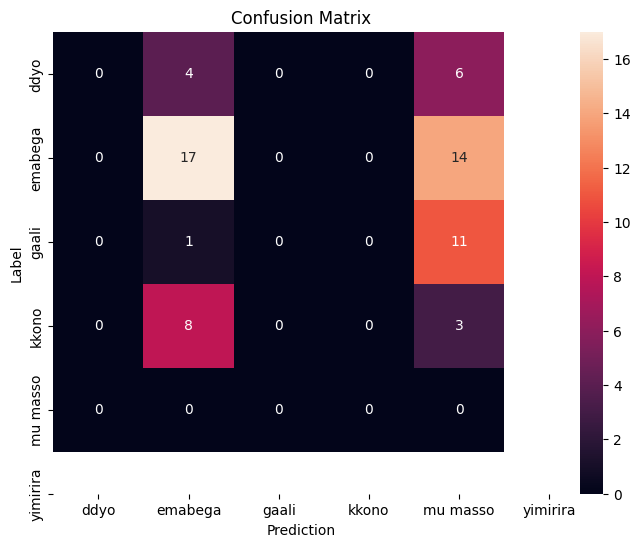

In [68]:
# Evaluate the model on the test dataset
y_true = []
y_pred = []

for spectrogram, label in test_spectrogram_ds:
    interpreter.set_tensor(input_details[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    y_true.append(label)
    y_pred.append(predicted_label)


confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [69]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')


Accuracy is 26%
